# Analysis of model output

In [36]:
from Model.AttentionDCA import AttentionDCA
from Model.train import train_model
from Utils.ppv_curve_utils import score, compute_PPV, compute_actualPPV
from Utils.representation_generator import GenerateRepresentation
from Utils.feature_importance import get_feature_importance
from Utils.read_fasta_utils import quickread
import matplotlib.pyplot as plt
import numpy as np
import torch
import json

# Set to False if saving plots is not required 
saveplots = True

# PF00014

<big>Defining constants and loading alignment matrix/hyperparameters</big>

In [2]:
if torch.cuda.is_available:
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

rep_names_list = ["onehot", "SLATM", "cMBDF", "SPAHM", "Morgan"]
fasta_file = "data/PF00014.fasta"
struct_file = "data/PF00014_struct.dat"
xyz_dir = "3d_struct_aa_xyz"
hyperparams_file = "best_hyperparams.json"
Z, W = quickread(fasta_file)
seq_len = Z.shape[0]
data_dict = {
    "Z": Z,
    "W": W,
}
dataloader_params = {
    "batch_size": Z.shape[1]//40,
    "shuffle": True,
    "num_workers": 10,
}

with open(hyperparams_file, "r") as f:
    hyperparams = json.loads(f.read())

<big>Model training for each representation</big>

In [3]:
models_list = []
for rep_name in rep_names_list:
    reps_matrix = torch.tensor(GenerateRepresentation(rep_name, xyz_dir), dtype=torch.float32).to(device)
    rep_hyperparams = hyperparams[rep_name + "_" + fasta_file]
    
    init_model = AttentionDCA(
        reps_matrix=reps_matrix,
        seq_len=seq_len,
        num_heads=rep_hyperparams["num_heads"],
        d_k=rep_hyperparams["d_k"],
        d_v=rep_hyperparams["d_v"],
        kernel_type="rbf",
        gamma_fact=rep_hyperparams["gamma_fact"],
        lambda_=rep_hyperparams["lambda_"],
    ).to(device)

    print(f"Training model for {rep_name} representation: ")
    model, _, _ = train_model(
        model=init_model,
        data_dict=data_dict,
        struct_file=struct_file,
        num_epoch=rep_hyperparams["num_epochs"],
        lr=rep_hyperparams["lr"],
        dataloader_params=dataloader_params,
    )

    models_list.append(model)
    

Training model for onehot representation: 


Generating SLATM representations: 


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Training model for SLATM representation: 


Generating cMBDF representations: 


100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Training model for cMBDF representation: 


Generating SPAHM representations: 


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Training model for SPAHM representation: 


Generating Morgan fingerprints: 


100%|██████████| 20/20 [00:00<00:00, 4120.34it/s]


Training model for Morgan representation: 


<big>Plotting PPV curves</big>

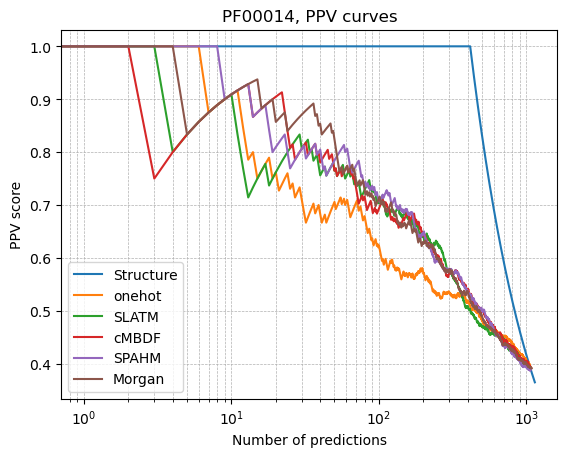

In [37]:
struct_ppv_curve = compute_actualPPV(struct_file).numpy()
num_preds = np.array(list(range(struct_ppv_curve.size)))
plt.plot(num_preds, struct_ppv_curve, label="Structure")

for i, rep_name in enumerate(rep_names_list):
    rep_ppv_curve = compute_PPV(score(models_list[i]), struct_file).cpu().detach().numpy()
    num_preds = np.array(list(range(rep_ppv_curve.size)))
    plt.plot(num_preds, rep_ppv_curve, label=rep_name)

plt.title("PF00014, PPV curves")
plt.xscale("log")
plt.xlabel("Number of predictions")
plt.ylabel("PPV score")

plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

if saveplots:
    plt.savefig("plots/ppv.png")
    
plt.show()

<big>Feature importance plot, one-hot</big>

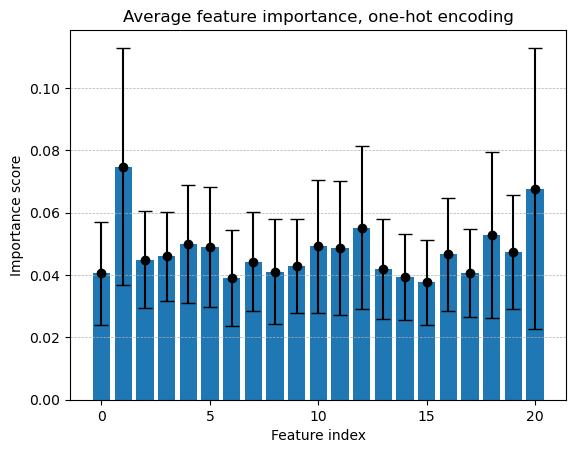

In [31]:
rep_name = "one-hot encoding"
rep_index = 0

mean_feat_importance, std_feat_importance = get_feature_importance(models_list[rep_index])
indices = np.array(list(range(mean_feat_importance.size)))

plt.title(f"Average feature importance, {rep_name}")
plt.xlabel("Feature index")
plt.ylabel("Importance score")
plt.bar(indices, mean_feat_importance)
plt.errorbar(indices, mean_feat_importance, capsize=5, fmt='o', color="black", yerr=std_feat_importance, label='Barres d\'erreur')
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)

if saveplots:
    plt.savefig("plots/oh_feat_imp.png")

plt.show()

<big>Feature importance plot, SPAHM</big>

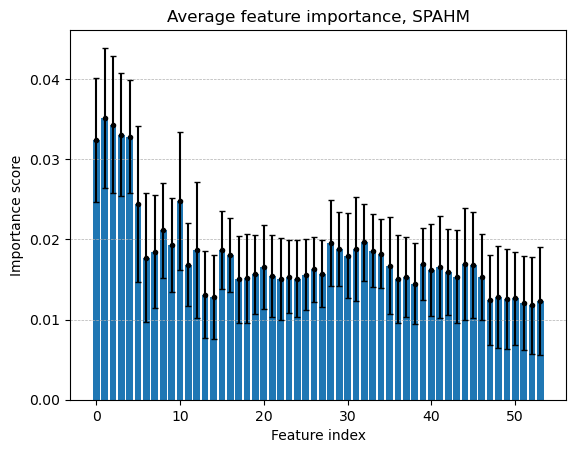

In [32]:
rep_name = "SPAHM"
rep_index = 3

mean_feat_importance, std_feat_importance = get_feature_importance(models_list[rep_index])
indices = np.array(list(range(mean_feat_importance.size)))

plt.title(f"Average feature importance, {rep_name}")
plt.xlabel("Feature index")
plt.ylabel("Importance score")
plt.bar(indices[:-1], mean_feat_importance[:-1])
plt.errorbar(indices[:-1], mean_feat_importance[:-1], capsize=2, fmt='.', color="black", yerr=std_feat_importance[:-1], label='Barres d\'erreur')
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)

if saveplots:
    plt.savefig("plots/spahm_feat_imp.png")

plt.show()